<a href="https://colab.research.google.com/github/koh-ts/human_activity_recognition/blob/master/human_activity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GroupKFold, cross_val_score
import pandas_profiling as pdp
from IPython.display import HTML
import lightgbm as lgb
from matplotlib import pyplot as plt
import pickle
%matplotlib inline

In [0]:
class ModelExtractionCallback(object):
    """lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス
    NOTE: 非公開クラス '_CVBooster' に依存しているため将来的に動かなく恐れがある
    """
    def __init__(self):
        self._model = None
    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model
    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')
    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model
    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters
    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration
#from: https://blog.amedama.jp/entry/lightgbm-cv-model

Mount your Google Drive. In this notebook, we assume that 'report2' folder is placed directly under 'My Drive'.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the data.

In [0]:
root_dir="/content/drive/My Drive/report2/"
nsample = 3000

xraw_train = pd.read_csv(root_dir+"X_train.csv",header=None)
yraw_train = pd.read_csv(root_dir+"y_train.csv",header=None)
xraw_test = pd.read_csv(root_dir+"X_test.csv",header=None)

In [0]:
with open(root_dir + 'corr_done.txt', 'rb') as f:
  lis = pickle.load(f)

In [22]:
xraw_train = xraw_train.drop(lis, axis=1)
xraw_test = xraw_test.drop(lis, axis=1)

KeyError: ignored

In [0]:
sub_train = pd.read_csv(root_dir + "subject_train.csv", header=None)

In [25]:
X_train = np.array(xraw_train)
y_train = np.array(yraw_train.ix[:,0])
X_test = np.array(xraw_test)
subject_train = np.array(sub_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


In [0]:
# subject_train.shape
# X_train.shape

In [0]:
XTrain = X_train[:nsample,:] #use the first 3000 samples for training
yTrain = y_train[:nsample]
XVal = X_train[nsample:,:] #use the rests for validation
yVal = y_train[nsample:]
alldata = pd.concat([xraw_train, xraw_test], ignore_index=True)

Train a linear SVM classifier

In [0]:
print("Training linear SVM classifier.")
clf = svm.LinearSVC()
clf.fit(XTrain,yTrain)

Evaluate training end validation scores.

In [0]:
yHatTrain = clf.predict(XTrain)
yHatVal = clf.predict(XVal)
print("Training score ", len((np.where(yHatTrain == yTrain))[0])*1.0/XTrain.shape[0])
print("Validation score ", len((np.where(yHatVal == yVal))[0])*1.0/XVal.shape[0])

In [0]:
group_kfold = GroupKFold(n_splits=15)
# for train_index, test_index in group_kfold.split(X_train, y_train, subject_train):
#   print(type(train_index), train_index)

In [0]:
train_data_set = lgb.Dataset(XTrain, yTrain)
valid_data_set = lgb.Dataset(XVal, yVal, reference=train_data_set)

# params = {'boosting_type': 'gbdt',
#           'objective': 'multiclass',
#           'num_class': 7,
#           'metric': {'multi_error'},
#           'num_leaves': 32,
#           'learning_rate': 0.05,
#           'feature_fraction': 0.9, #0.9
#           'bagging_fraction': 0.8, #0.8
#           'bagging_freq': 7}

params = {'objective': 'multiclass',
          'num_class': 7,
          'metric': {'multi_error'}}
extraction_cb = ModelExtractionCallback()
callbacks = [extraction_cb,]

In [50]:
train_data_for_cv = lgb.Dataset(X_train, y_train)
gbm_result = lgb.cv(params, train_data_for_cv, folds=group_kfold.split(X_train, y_train, subject_train), verbose_eval=True, callbacks=callbacks,)

[1]	cv_agg's multi_error: 0.220995 + 0.0870768
[2]	cv_agg's multi_error: 0.155829 + 0.0683834
[3]	cv_agg's multi_error: 0.142436 + 0.0641543
[4]	cv_agg's multi_error: 0.136386 + 0.0628693
[5]	cv_agg's multi_error: 0.131344 + 0.0622771
[6]	cv_agg's multi_error: 0.127 + 0.0617156
[7]	cv_agg's multi_error: 0.123493 + 0.0610599
[8]	cv_agg's multi_error: 0.118786 + 0.0607938
[9]	cv_agg's multi_error: 0.117706 + 0.0613351
[10]	cv_agg's multi_error: 0.117868 + 0.062362
[11]	cv_agg's multi_error: 0.117774 + 0.0616584
[12]	cv_agg's multi_error: 0.119398 + 0.0625354
[13]	cv_agg's multi_error: 0.117319 + 0.0618316
[14]	cv_agg's multi_error: 0.118638 + 0.0631235
[15]	cv_agg's multi_error: 0.117843 + 0.062081
[16]	cv_agg's multi_error: 0.117024 + 0.0617497
[17]	cv_agg's multi_error: 0.115397 + 0.0607829
[18]	cv_agg's multi_error: 0.115801 + 0.061921
[19]	cv_agg's multi_error: 0.115236 + 0.0623187
[20]	cv_agg's multi_error: 0.114549 + 0.061745
[21]	cv_agg's multi_error: 0.113834 + 0.060373
[22]	cv_a

In [0]:
proxy = extraction_cb.boosters_proxy
boosters = extraction_cb.raw_boosters
best_iteration = extraction_cb.best_iteration

In [0]:
y_pred_proba_list = proxy.predict(X_test, num_iteration=best_iteration)
y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
y_pred = np.argmax(y_pred_proba_avg, axis=1)

In [54]:
print(y_pred)
np.savetxt(root_dir+'result_gbm_cv.txt', y_pred)

[1 4 5 ... 3 4 1]


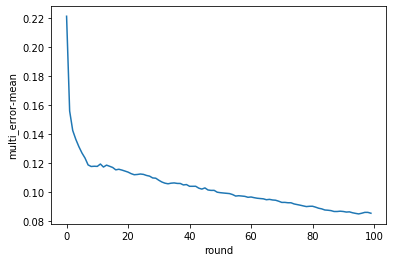

In [47]:
round_n = np.arange(len(gbm_result['multi_error-mean']))
plt.xlabel('round')
plt.ylabel('multi_error-mean')
plt.plot(round_n, gbm_result['multi_error-mean'])
plt.show()

Predict test data and save the result.

In [0]:
lgb.plot_importance(gbm)
plt.show()

In [0]:
yHatTest_gbm_raw = gbm.predict(X_test)
yHatTest_gbm = np.argmax(yHatTest_gbm_raw, axis=1)
np.savetxt(root_dir+'result_gbm2.txt', yHatTest_gbm)

In [0]:
yHatTest = clf.predict(X_test)
np.savetxt(root_dir+'result_svm.txt', yHatTest)